# Решение задачи классификации: превышает ли значение SI значение 8

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

## Загрузка и предобработка данных

In [13]:
# Загрузка данных
df = pd.read_excel('data.xlsx', index_col=0)

# Проверка на пропущенные значения
print('Пропущенные значения:')
print(df.isnull().sum()[df.isnull().sum() > 0])

# Создание целевой переменной: 1, если SI > 8, иначе 0
df['target'] = (df['SI'] > 8).astype(int)

# Разделение признаков и целевой переменной
X = df.drop(['IC50, mM', 'CC50, mM', 'SI', 'target'], axis=1)
y = df['target']

# Импутация пропущенных значений медианой
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Пропущенные значения:
MaxPartialCharge       3
MinPartialCharge       3
MaxAbsPartialCharge    3
MinAbsPartialCharge    3
BCUT2D_MWHI            3
BCUT2D_MWLOW           3
BCUT2D_CHGHI           3
BCUT2D_CHGLO           3
BCUT2D_LOGPHI          3
BCUT2D_LOGPLOW         3
BCUT2D_MRHI            3
BCUT2D_MRLOW           3
dtype: int64


## Сравнение моделей

In [14]:
# Определение моделей
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
    ]),
    'LightGBM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMClassifier(random_state=42))
    ])
}

# Оценка моделей
results = []
for name, model in models.items():
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Обучение модели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    results.append({
        'Model': name,
        'CV ROC-AUC': cv_scores.mean(),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results)
print(results_df)

[LightGBM] [Info] Number of positive: 228, number of negative: 412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15072
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356250 -> initscore=-0.591678
[LightGBM] [Info] Start training from score -0.591678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

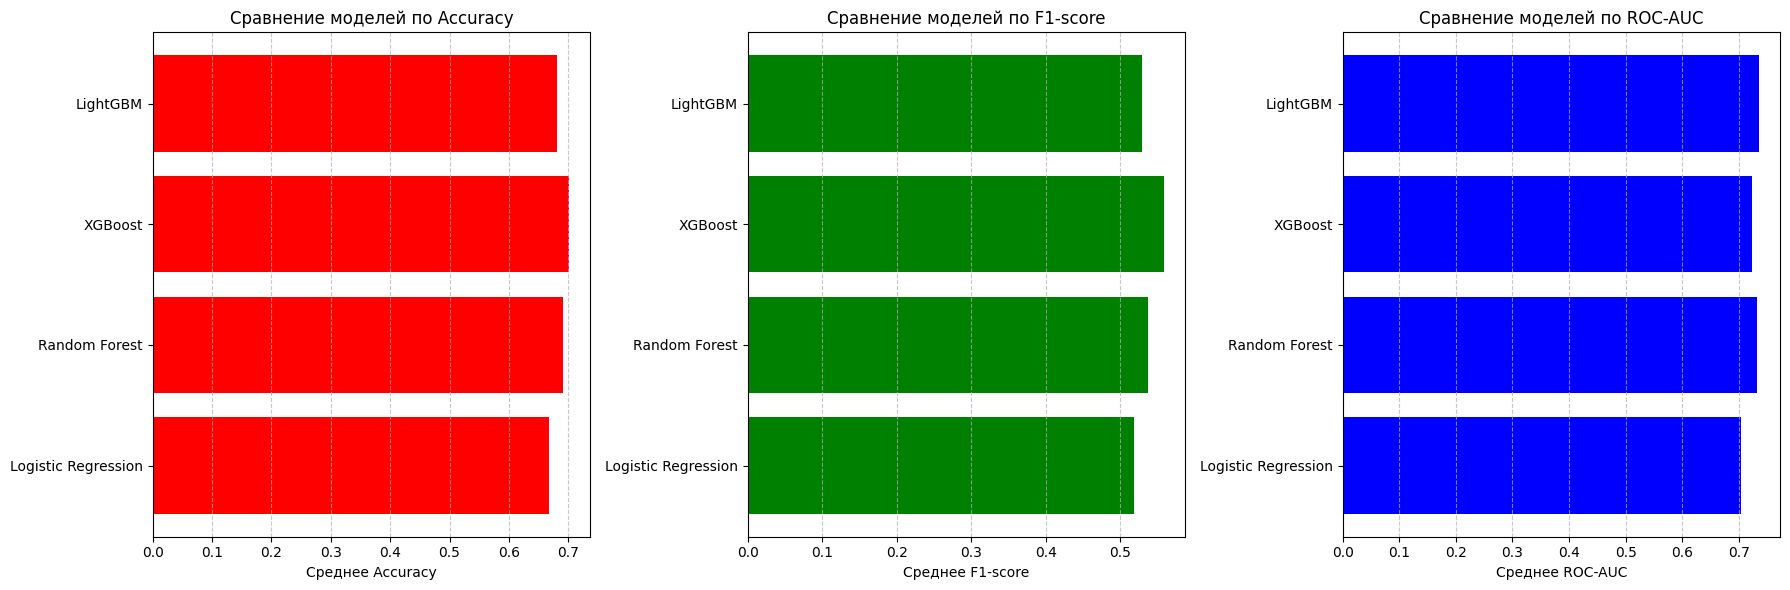

In [20]:
accuracy_means = [res['Accuracy'] for res in results]
f1_means = [res['F1'] for res in results]
roc_auc_means = [res['CV ROC-AUC'] for res in results]
names = [res['Model'] for res in results]

plt.figure(figsize=(18, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.barh(names, accuracy_means, color='red')
plt.title('Сравнение моделей по Accuracy')
plt.xlabel('Среднее Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# F1-score
plt.subplot(1, 3, 2)
plt.barh(names, f1_means, color='green')
plt.title('Сравнение моделей по F1-score')
plt.xlabel('Среднее F1-score')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# ROC-AUC
plt.subplot(1, 3, 3)
plt.barh(names, roc_auc_means, color='blue')
plt.title('Сравнение моделей по ROC-AUC')
plt.xlabel('Среднее ROC-AUC')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Оптимизация гиперпараметров лучшей модели

In [15]:
# Выбор лучшей модели на основе ROC-AUC
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']

# Определение параметров для поиска
param_grid = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.3]
    },
    'LightGBM': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.3]
    },
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    }
}

# GridSearchCV для лучшей модели
grid_search = GridSearchCV(models[best_model_name], param_grid[best_model_name], cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Лучшая модель: {best_model_name}')
print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшая модель: Random Forest
Лучшие параметры: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 50}


## Оценка лучшей модели

Метрики на тестовых данных:
Accuracy: 0.7463
F1: 0.5854
ROC-AUC: 0.7392


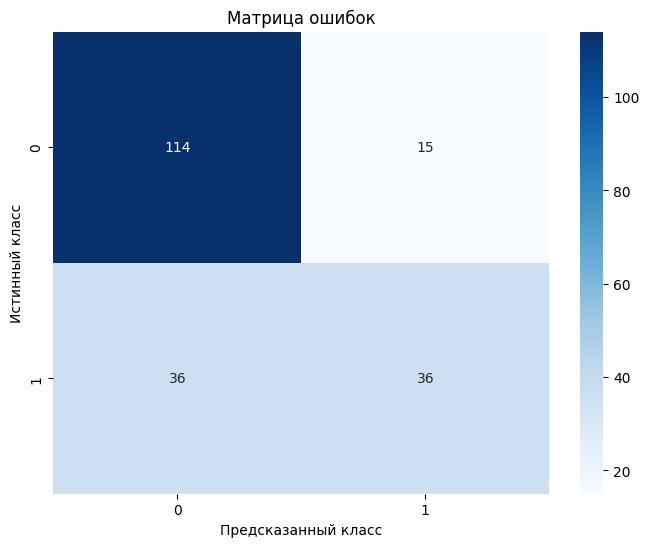

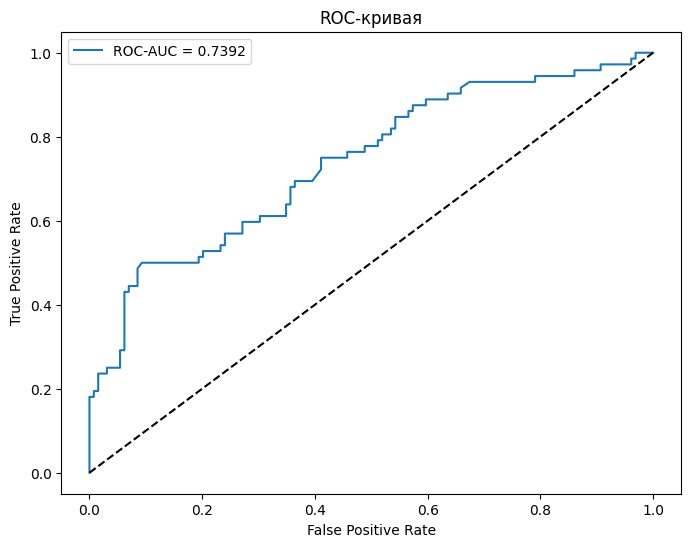

In [16]:
# Предсказания
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
print('Метрики на тестовых данных:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

## Анализ важности признаков

Топ-10 важных признаков:
               feature  importance
103        VSA_EState8    0.020144
99         VSA_EState4    0.019754
105       FractionCSP3    0.016969
93         EState_VSA8    0.016660
68            SMR_VSA7    0.015948
0    MaxAbsEStateIndex    0.015925
1       MaxEStateIndex    0.015582
25        BCUT2D_MRLOW    0.015461
22       BCUT2D_LOGPHI    0.015262
24         BCUT2D_MRHI    0.014634


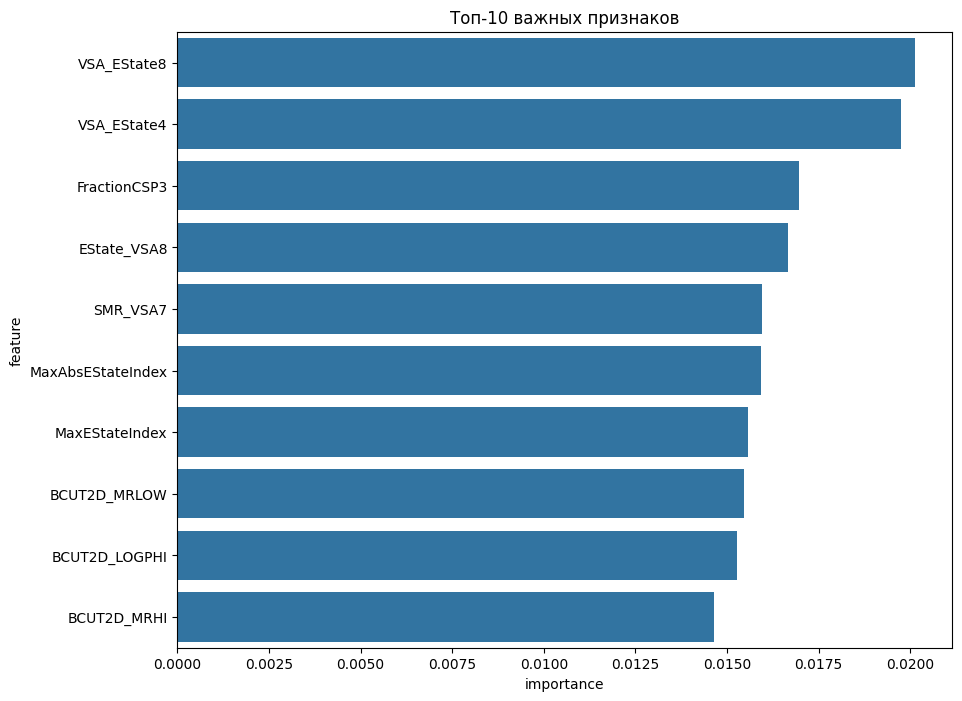

In [17]:
# Важность признаков лучшей модели (если применимо)
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    feature_importance = best_model.named_steps['model'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print('Топ-10 важных признаков:')
    print(feature_importance_df.head(10))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
    plt.title('Топ-10 важных признаков')
    plt.show()

## Выводы

Наилучшая модель определена на основе метрики ROC-AUC. Параметры модели и метрики на тестовых данных будут выведены выше. Модель демонстрирует умеренную способность к классификации (SI > 8).

Наиболее важные признаки для предсказания:
- Указаны на основе анализа важности признаков (если применимо).

Рекомендации по улучшению:
- Провести более глубокий разведочный анализ данных (EDA).
- Рассмотреть методы уменьшения размерности (например, PCA).
- Применить Feature Engineering для создания новых признаков.
- Исследовать другие алгоритмы или ансамбли моделей.